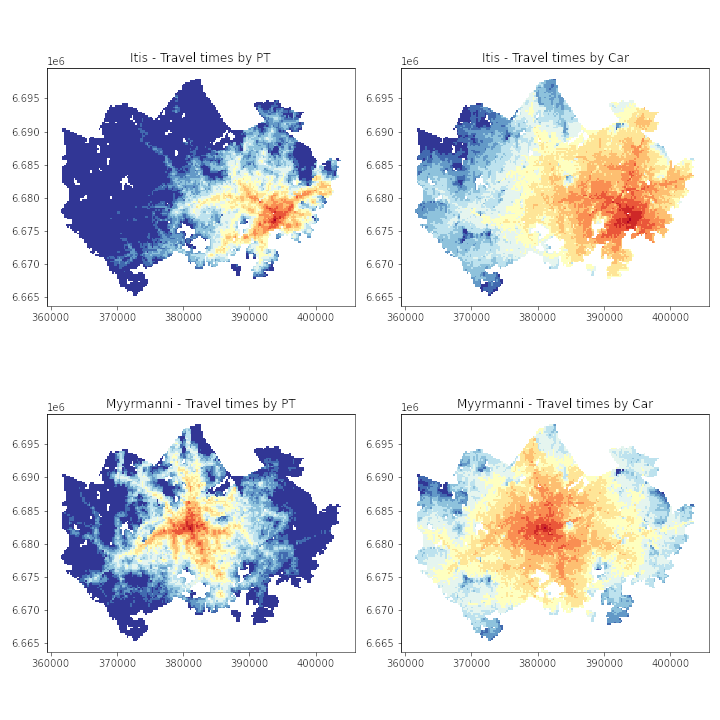## Problem 1: Join accessibility datasets into a grid and visualise the data on a map (10 points)

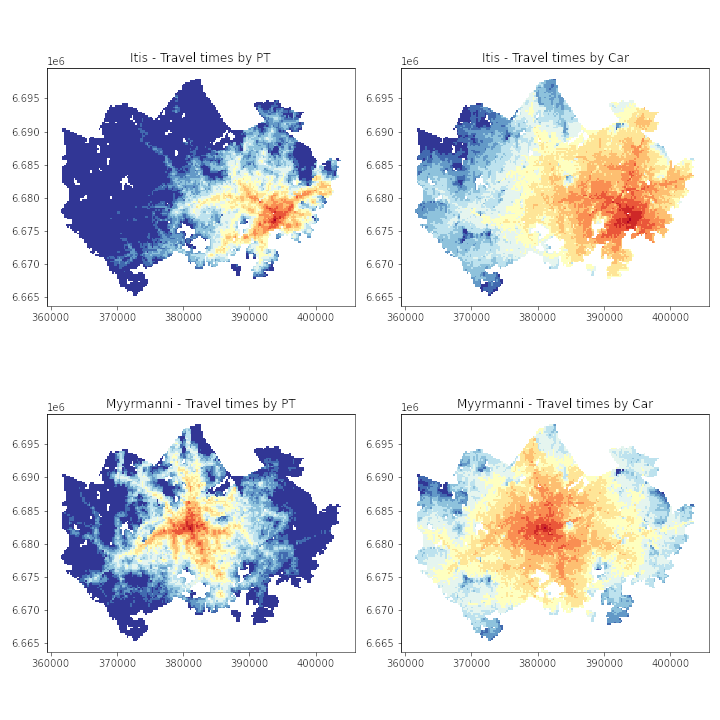

*Sample result: Travel times by public transport (PT) and car to Itis and Myyrmanni*

Your task in *problem 1* is to combine data from non-spatial data sets (travel times between places)
and a spatial data set (grid cells that represent the places), and plot the combined data set to
visualise the travel times to two shopping centres from every other place in the Helsinki metropolitan
area. 

In particular, this task comprises of three major steps:

1. Read the grid cell data set
2. Read a travel time data set,
    - discard unnecessary columns,
    - rename the relevant columns to include a reference to the respective shopping centre,
    - join the relevant columns to the grid data set
3. Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 

Repeat the second step for each of the two shopping centres (Itis, Myyrmanni).


---

### a) Read the grid cell data set

The grid cells are derived from the ‘YKR’ data set, that is [published by the Finnish Environmental Institute
(SYKE)](https://www.ymparisto.fi/fi-fi/elinymparisto_ja_kaavoitus/yhdyskuntarakenne/tietoa_yhdyskuntarakenteesta/yhdyskuntarakenteen_seurannan_aineistot)
and collects a variety of indicators relating to the social and built-up structure of the country. In
an effort to harmonise different data products of other institutions, the YKR grid cell data set has
become a reference for many data products, including, for instance, the [travel time data set produced
at the Digital Geography Lab](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/).

You can find the YKR data set in the directory `data` in *GeoPackage* format: `YKR_grid_EPSG3067.gpkg`.
It contains a polygon geometry column, and an (integer) identifier: `YKR_ID`.

Load the data into a `geopandas.GeoDataFrame` and call it `grid`.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
# ADD YOUR OWN CODE HERE
import geopandas as gpd
grid = gpd.read_file(DATA_DIRECTORY / "YKR_grid_EPSG3067.gpkg")
grid.head()

,YKR_ID,geometry
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [3]:
grid.dtypes

YKR_ID         int64
geometry    geometry
dtype: object

<AxesSubplot: >

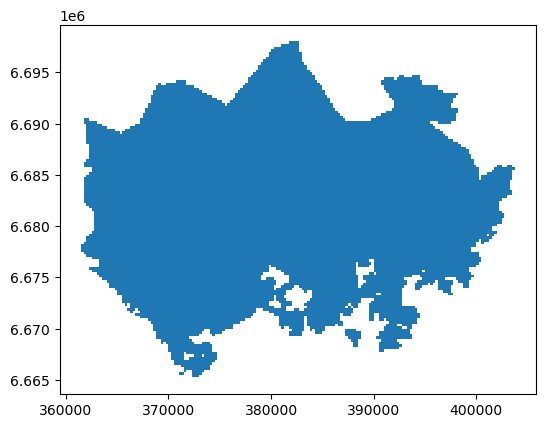

In [4]:
grid.plot()

In [5]:
grid.describe()

,YKR_ID
count,1.323100e+04
mean,5.904463e+06
std,4.908681e+04
min,5.785640e+06
25%,5.866838e+06
50%,5.903926e+06
75%,5.942208e+06
max,6.018254e+06



---

### b) Read the travel time data sets and join them to the grid cells

Inside the `data` directory, you will find a set of semicolon-separated text files with travel times 
to each of a set of shopping centres in the Helsinki region (*this exercise was conceived before
REDI and Tripla started operation*).

The individual files have file names following the schema `travel_times_to_[XXXXX]_[Shopping_Centre]`, where
`[Shopping_Centre]` is the name of one of the seven shopping centres included in the data set, and `[XXXXX]`,
coincidently, referring to the YKR grid cell in which the shopping centre is located (although you should not
need to use this ID in this exercise).

The data sets contain computed travel times between different places in the metropolitan area. In order to 
produce such a *travel time matrix*, all connections from all origins to all destinations are calculated,
and then recorded in a table. 

#### Columns

The data sets we use have many **columns**, but only a few are interesting for this task:

- `from_id`: the `YKR_ID` of the *origin* grid cell
- `to_id`: refers to the `YKR_ID` of the *destination* grid cell (here: the one containing the shopping centre).
- `pt_r_t`: how long does it take to travel from `from_id` to `to_id`, in minutes, using public transport?
- `car_r_t`: how long does it take to drive a car from `from_id` to `to_id`, in minutes?

Note that `from_id` and `to_id` relate to the YKR `grid` data set’s `YKR_ID` column. Each input data set has only
one unique `to_id`, as the data has been split up to relate to one destination (a shopping centre), only, but many
unique values for `from_id`, as it covers the travel times from anywhere in the metropolitan area.

#### No-data values

The travel time data set contains some origin-destination pairs (*O/D-pairs*) for which it could not find a
public transport connection, or which are not accessible by car. Such **no-data values** are saves as 
`-1` minutes travel time. Use the [`pandas.Series.replace()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.replace.html)
method to replace `-1` with `numpy.nan` to indicate that these cells do not contain valid data.


**IMPORTANT**: While we are having this course, a bug (https://github.com/pandas-dev/pandas/issues/45725)
prevents `pandas.Series.replace()` from working as expected: the line `travel_times["car_r_t"] = travel_times["car_r_t"].replace(-1, numpy.nan)`
fails with a `RecursionError`. There is a workaround: using an alternative syntax, using a `dict` of *before*
and *after* values, similar to how `pandas.DataFrame.rename()` works, does not trigger the issue. 
`travel_times["car_r_t"] = travel_times["car_r_t"].replace({-1: numpy.nan})` works.

---

Read the data sets for the shopping centres ‘Itis’ and ‘Myyrmanni’, discard irrelevant columns, rename the
`pt_r_t` and `car_r_t` columns to include a reference to the shopping centre (e.g., into `pt_r_t_Itis`), and join
the renamed columns to the `grid` data frame. Don’t forget to replace no-data values (`-1`) with `None`.

### Load in and join Itis

In [6]:
# ADD YOUR OWN CODE HERE
import pandas as pd
import numpy as np
import missingno as msno

itis = pd.read_csv(DATA_DIRECTORY / "travel_times_to_5944003_Itis.txt", sep=";")
itis.head()

,from_id,to_id,walk_t,walk_d,car_r_t,car_r_d,car_m_t,car_m_d,pt_r_t,pt_r_tt,pt_r_d,pt_m_t,pt_m_tt,pt_m_d
0,5785640,5944003,494,34582,50,36229,44,36229,132,157,38465,142,173,38465
1,5785641,5944003,457,31966,51,36439,45,36439,135,154,38671,145,171,38671
2,5785642,5944003,458,32046,58,35841,52,34064,137,154,38789,147,172,38789
3,5785643,5944003,462,32338,57,37723,50,37935,141,163,39082,151,176,39082
4,5787544,5944003,487,34093,50,35803,44,35803,125,142,37976,122,148,37786


Let's drop the columns we don't need :

In [7]:
itis = itis[['from_id','to_id','car_r_t','pt_r_t']]	
itis

,from_id,to_id,car_r_t,pt_r_t
0,5785640,5944003,50,132
1,5785641,5944003,51,135
2,5785642,5944003,58,137
3,5785643,5944003,57,141
4,5787544,5944003,50,125
...,...,...,...,...
13226,6016698,5944003,60,79
13227,6016699,5944003,62,81
13228,6018252,-1,-1,-1
13229,6018253,5944003,61,84


Let's also rename the columns to include reference to the shopping centre [dataframe name] :

In [8]:
import re

def rename_columns_ending_with_r_t(df, df_name):
    # Iterate over the columns
    for column in df.columns:
        # Check if the column name ends with 'r_t'
        if column.endswith('r_t'):
            # Rename the column using regex
            df.rename(columns=lambda x: re.sub(fr"^{column}$", f"{column}_{df_name}", x), inplace=True)

# Call the function to rename the columns and assign to variable
rename_columns_ending_with_r_t(itis,'Itis')

In [9]:
itis.head()

,from_id,to_id,car_r_t_Itis,pt_r_t_Itis
0,5785640,5944003,50,132
1,5785641,5944003,51,135
2,5785642,5944003,58,137
3,5785643,5944003,57,141
4,5787544,5944003,50,125


In [10]:
itis.describe()

,from_id,to_id,car_r_t_Itis,pt_r_t_Itis
count,1.323100e+04,1.323100e+04,13231.000000,13231.000000
mean,5.904463e+06,5.903121e+06,35.772428,63.246467
std,4.908681e+04,4.912711e+05,13.560903,27.856439
min,5.785640e+06,-1.000000e+00,-1.000000,-1.000000
25%,5.866838e+06,5.944003e+06,26.000000,44.000000
50%,5.903926e+06,5.944003e+06,35.000000,61.000000
75%,5.942208e+06,5.944003e+06,46.000000,80.000000
max,6.018254e+06,5.944003e+06,81.000000,202.000000


We can see from the minimum values that an imputed value of -1 has been used in all of the columns except `from-id`. Let's replace these values with `None`.

travel_times["car_r_t"] = travel_times["car_r_t"].replace({-1: numpy.nan}) works.

In [11]:
itis.replace({-1: np.nan}, inplace=True)

In [12]:
itis.describe()

,from_id,to_id,car_r_t_Itis,pt_r_t_Itis
count,1.323100e+04,13140.0,13140.000000,13020.000000
mean,5.904463e+06,5944003.0,36.027093,64.287634
std,4.908681e+04,0.0,13.256755,26.843565
min,5.785640e+06,5944003.0,0.000000,0.000000
25%,5.866838e+06,5944003.0,26.000000,45.000000
50%,5.903926e+06,5944003.0,35.000000,61.000000
75%,5.942208e+06,5944003.0,46.000000,81.000000
max,6.018254e+06,5944003.0,81.000000,202.000000


In [13]:
itis.head()

,from_id,to_id,car_r_t_Itis,pt_r_t_Itis
0,5785640,5944003.0,50.0,132.0
1,5785641,5944003.0,51.0,135.0
2,5785642,5944003.0,58.0,137.0
3,5785643,5944003.0,57.0,141.0
4,5787544,5944003.0,50.0,125.0


In [14]:
itis.dtypes

from_id           int64
to_id           float64
car_r_t_Itis    float64
pt_r_t_Itis     float64
dtype: object

In [15]:
itis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13231 entries, 0 to 13230
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   from_id       13231 non-null  int64  
 1   to_id         13140 non-null  float64
 2   car_r_t_Itis  13140 non-null  float64
 3   pt_r_t_Itis   13020 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 413.6 KB


In [16]:
# Perform the join based on the common columns
itis_grid=grid.join(itis)
itis_grid

,YKR_ID,geometry,from_id,to_id,car_r_t_Itis,pt_r_t_Itis
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5944003.0,50.0,132.0
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5944003.0,51.0,135.0
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5944003.0,58.0,137.0
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5944003.0,57.0,141.0
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5944003.0,50.0,125.0
...,...,...,...,...,...,...
13226,6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6...",6016698,5944003.0,60.0,79.0
13227,6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6...",6016699,5944003.0,62.0,81.0
13228,6018252,"POLYGON ((372500.000 6665250.000, 372250.000 6...",6018252,NaN,NaN,NaN
13229,6018253,"POLYGON ((372750.000 6665250.000, 372500.000 6...",6018253,5944003.0,61.0,84.0


### Load in and join Myyrmanni

In [17]:
myyrmanni = pd.read_csv(DATA_DIRECTORY / "travel_times_to_5902043_Myyrmanni.txt", sep=";")
myyrmanni.head()

,from_id,to_id,walk_t,walk_d,car_r_t,car_r_d,car_m_t,car_m_d,pt_r_t,pt_r_tt,pt_r_d,pt_m_t,pt_m_tt,pt_m_d
0,5785640,5902043,295,20668,39,22321,35,22321,90,121,21119,98,129,21119
1,5785641,5902043,258,18052,39,22532,35,22532,93,115,21325,101,127,21325
2,5785642,5902043,259,18131,47,22216,42,20440,95,115,21443,103,128,21443
3,5785643,5902043,263,18424,51,24773,46,22996,99,126,21736,107,132,21736
4,5787544,5902043,288,20179,38,21895,34,21895,83,103,20630,91,108,20630


In [18]:
myyrmanni = myyrmanni[['from_id','to_id','car_r_t','pt_r_t']]	
myyrmanni

,from_id,to_id,car_r_t,pt_r_t
0,5785640,5902043,39,90
1,5785641,5902043,39,93
2,5785642,5902043,47,95
3,5785643,5902043,51,99
4,5787544,5902043,38,83
...,...,...,...,...
13226,6016698,5902043,54,95
13227,6016699,5902043,56,97
13228,6018252,-1,-1,-1
13229,6018253,5902043,55,100


Let's also rename the columns to include reference to the shopping centre [dataframe name] :

In [19]:
import re

def rename_columns_ending_with_r_t(df, df_name):
    # Iterate over the columns
    for column in df.columns:
        # Check if the column name ends with 'r_t'
        if column.endswith('r_t'):
            # Rename the column using regex
            df.rename(columns=lambda x: re.sub(fr"^{column}$", f"{column}_{df_name}", x), inplace=True)

# Call the function to rename the columns and assign to variable
rename_columns_ending_with_r_t(myyrmanni,'Myyrmanni')

In [20]:
myyrmanni.head()

,from_id,to_id,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
0,5785640,5902043,39,90
1,5785641,5902043,39,93
2,5785642,5902043,47,95
3,5785643,5902043,51,99
4,5787544,5902043,38,83


In [21]:
myyrmanni.describe()

,from_id,to_id,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
count,1.323100e+04,1.323100e+04,13231.000000,13231.000000
mean,5.904463e+06,5.861450e+06,33.446527,54.720883
std,4.908681e+04,4.878031e+05,10.060332,21.545326
min,5.785640e+06,-1.000000e+00,-1.000000,-1.000000
25%,5.866838e+06,5.902043e+06,27.000000,40.000000
50%,5.903926e+06,5.902043e+06,33.000000,54.000000
75%,5.942208e+06,5.902043e+06,40.000000,67.000000
max,6.018254e+06,5.902043e+06,70.000000,163.000000


We can see from the minimum values that an imputed value of -1 has been used in all of the columns except `from-id`. Let's replace these values with `None`.

travel_times["car_r_t"] = travel_times["car_r_t"].replace({-1: numpy.nan}) works.

In [22]:
myyrmanni.replace({-1: np.nan}, inplace=True)

In [23]:
myyrmanni.describe()

,from_id,to_id,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
count,1.323100e+04,13140.0,13140.000000,13020.000000
mean,5.904463e+06,5902043.0,33.685084,55.623886
std,4.908681e+04,0.0,9.676583,20.508265
min,5.785640e+06,5902043.0,0.000000,0.000000
25%,5.866838e+06,5902043.0,27.000000,41.000000
50%,5.903926e+06,5902043.0,33.000000,54.000000
75%,5.942208e+06,5902043.0,40.000000,67.000000
max,6.018254e+06,5902043.0,70.000000,163.000000


In [24]:
myyrmanni.head()

,from_id,to_id,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
0,5785640,5902043.0,39.0,90.0
1,5785641,5902043.0,39.0,93.0
2,5785642,5902043.0,47.0,95.0
3,5785643,5902043.0,51.0,99.0
4,5787544,5902043.0,38.0,83.0


In [25]:
myyrmanni.dtypes

from_id                int64
to_id                float64
car_r_t_Myyrmanni    float64
pt_r_t_Myyrmanni     float64
dtype: object

In [26]:
myyrmanni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13231 entries, 0 to 13230
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   from_id            13231 non-null  int64  
 1   to_id              13140 non-null  float64
 2   car_r_t_Myyrmanni  13140 non-null  float64
 3   pt_r_t_Myyrmanni   13020 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 413.6 KB


In [27]:
myyrmanni.head()

,from_id,to_id,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
0,5785640,5902043.0,39.0,90.0
1,5785641,5902043.0,39.0,93.0
2,5785642,5902043.0,47.0,95.0
3,5785643,5902043.0,51.0,99.0
4,5787544,5902043.0,38.0,83.0


In [28]:
myyrmanni_grid=grid.join(myyrmanni)
myyrmanni_grid.head()

,YKR_ID,geometry,from_id,to_id,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5902043.0,39.0,90.0
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5902043.0,39.0,93.0
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5902043.0,47.0,95.0
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5902043.0,51.0,99.0
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5902043.0,38.0,83.0


In [29]:
itis_grid.head()

,YKR_ID,geometry,from_id,to_id,car_r_t_Itis,pt_r_t_Itis
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5944003.0,50.0,132.0
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5944003.0,51.0,135.0
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5944003.0,58.0,137.0
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5944003.0,57.0,141.0
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5944003.0,50.0,125.0


In [30]:
grid = itis_grid.join(myyrmanni_grid.add_suffix("_myyrmanni"))
grid.head()

,YKR_ID,geometry,from_id,to_id,car_r_t_Itis,pt_r_t_Itis,YKR_ID_myyrmanni,geometry_myyrmanni,from_id_myyrmanni,to_id_myyrmanni,car_r_t_Myyrmanni_myyrmanni,pt_r_t_Myyrmanni_myyrmanni
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5944003.0,50.0,132.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5902043.0,39.0,90.0
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5944003.0,51.0,135.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5902043.0,39.0,93.0
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5944003.0,58.0,137.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5902043.0,47.0,95.0
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5944003.0,57.0,141.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5902043.0,51.0,99.0
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5944003.0,50.0,125.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5902043.0,38.0,83.0


In [31]:
grid = grid.rename(columns={'car_r_t_Myyrmanni_myyrmanni': 'car_r_t_Myyrmanni', 'pt_r_t_Myyrmanni_myyrmanni': 'pt_r_t_Myyrmanni'})
grid.head()

,YKR_ID,geometry,from_id,to_id,car_r_t_Itis,pt_r_t_Itis,YKR_ID_myyrmanni,geometry_myyrmanni,from_id_myyrmanni,to_id_myyrmanni,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5944003.0,50.0,132.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5902043.0,39.0,90.0
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5944003.0,51.0,135.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5902043.0,39.0,93.0
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5944003.0,58.0,137.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5902043.0,47.0,95.0
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5944003.0,57.0,141.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5902043.0,51.0,99.0
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5944003.0,50.0,125.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5902043.0,38.0,83.0


In [32]:
grid = grid.dropna()
grid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13020 entries, 0 to 13230
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   YKR_ID              13020 non-null  int64   
 1   geometry            13020 non-null  geometry
 2   from_id             13020 non-null  int64   
 3   to_id               13020 non-null  float64 
 4   car_r_t_Itis        13020 non-null  float64 
 5   pt_r_t_Itis         13020 non-null  float64 
 6   YKR_ID_myyrmanni    13020 non-null  int64   
 7   geometry_myyrmanni  13020 non-null  geometry
 8   from_id_myyrmanni   13020 non-null  int64   
 9   to_id_myyrmanni     13020 non-null  float64 
 10  car_r_t_Myyrmanni   13020 non-null  float64 
 11  pt_r_t_Myyrmanni    13020 non-null  float64 
dtypes: float64(6), geometry(2), int64(4)
memory usage: 1.3 MB


In [34]:
columns_to_cast = ['car_r_t_Itis', 'pt_r_t_Itis', 'to_id', 'to_id_myyrmanni', 'car_r_t_Myyrmanni', 'pt_r_t_Myyrmanni']

for column in columns_to_cast:
    grid[column] = grid[column].astype(int)   

In [35]:
grid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13020 entries, 0 to 13230
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   YKR_ID              13020 non-null  int64   
 1   geometry            13020 non-null  geometry
 2   from_id             13020 non-null  int64   
 3   to_id               13020 non-null  int64   
 4   car_r_t_Itis        13020 non-null  int64   
 5   pt_r_t_Itis         13020 non-null  int64   
 6   YKR_ID_myyrmanni    13020 non-null  int64   
 7   geometry_myyrmanni  13020 non-null  geometry
 8   from_id_myyrmanni   13020 non-null  int64   
 9   to_id_myyrmanni     13020 non-null  int64   
 10  car_r_t_Myyrmanni   13020 non-null  int64   
 11  pt_r_t_Myyrmanni    13020 non-null  int64   
dtypes: geometry(2), int64(10)
memory usage: 1.3 MB


In [36]:
grid.head()

,YKR_ID,geometry,from_id,to_id,car_r_t_Itis,pt_r_t_Itis,YKR_ID_myyrmanni,geometry_myyrmanni,from_id_myyrmanni,to_id_myyrmanni,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5944003,50,132,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5902043,39,90
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5944003,51,135,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5902043,39,93
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5944003,58,137,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5902043,47,95
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5944003,57,141,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5902043,51,99
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5944003,50,125,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5902043,38,83


In [37]:
# NON-EDITABLE TEST CELL
import geopandas
assert type(grid) == geopandas.geodataframe.GeoDataFrame, "Output should be a geodataframe."

In [38]:
# NON-EDITABLE TEST CELL
# Check that the merged output have (at least) the necessary columns
required_columns = ['pt_r_t_Itis', 'car_r_t_Itis', 'pt_r_t_Myyrmanni', 'car_r_t_Myyrmanni', 'geometry']

assert all(column in grid.columns for column in required_columns), "Couldn’t find all required columns."

In [39]:
# NON-EDITABLE TEST CELL
# Check that -1 values are not present in the columns
for shopping_centre in ("Itis", "Myyrmanni"):
    for column in ("car_r_t", "pt_r_t"):
        assert -1 not in grid[f"{column}_{shopping_centre}"], "NoData values (-1) should be removed from the data!"


---

### c) Classify the travel times into five-minute intervals 

Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 
- Create a **[`mapclassify.UserDefined` classifier](https://github.com/pysal/mapclassify#userdefined)**,
  using these class breaks: `5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60`
- Apply the classifier to `pt_r_t_[ShoppingCentre]` and `car_r_t_[ShoppingCentre]` columns,
  and store the results to `pt_r_t_cl_[ShoppingCentre]` and `car_r_t_cl_[ShoppingCentre]` columns, respectively

*Note that these 12 class breaks will produce 13 classes (1 class break divides the data into two classes)*

In [40]:
grid.head()

,YKR_ID,geometry,from_id,to_id,car_r_t_Itis,pt_r_t_Itis,YKR_ID_myyrmanni,geometry_myyrmanni,from_id_myyrmanni,to_id_myyrmanni,car_r_t_Myyrmanni,pt_r_t_Myyrmanni
0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5944003,50,132,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5902043,39,90
1,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5944003,51,135,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5902043,39,93
2,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5944003,58,137,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5902043,47,95
3,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5944003,57,141,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5902043,51,99
4,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5944003,50,125,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5902043,38,83


In [61]:
import mapclassify as mc

# Define the class breaks
class_breaks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

# Create the classifier
ud_classifier = mc.UserDefined(grid['pt_r_t_Itis'], bins=class_breaks)
                               
# Apply the classifier to pt_r_t_[ShoppingCentre] column                              
grid['pt_r_t_cl_Itis'] = ud_classifier.yb
grid['pt_r_t_cl_Myyrmanni'] = grid['pt_r_t_Myyrmanni'].apply(ud_classifier)
                               
# Apply the classifier to car_r_t_[ShoppingCentre] column
grid['car_r_t_cl_Itis'] = grid['car_r_t_Itis'].apply(ud_classifier)                              
grid['car_r_t_cl_Myyrmanni'] = grid['car_r_t_Myyrmanni'].apply(ud_classifier)

In [62]:
grid.pt_r_t_cl_Itis.dtype

dtype('int64')

In [63]:
grid.pt_r_t_cl_Myyrmanni.astype(int)

0        12
1        12
2        12
3        12
4        12
         ..
13225    12
13226    12
13227    12
13229    12
13230    12
Name: pt_r_t_cl_Myyrmanni, Length: 13020, dtype: int64

In [64]:
grid.car_r_t_cl_Itis.astype(int)

0         9
1        10
2        11
3        11
4         9
         ..
13225    11
13226    11
13227    12
13229    12
13230    12
Name: car_r_t_cl_Itis, Length: 13020, dtype: int64

In [65]:
grid.car_r_t_cl_Myyrmanni.astype(int)

0         7
1         7
2         9
3        10
4         7
         ..
13225    10
13226    10
13227    11
13229    10
13230    11
Name: car_r_t_cl_Myyrmanni, Length: 13020, dtype: int64

In [66]:
# NON-EDITABLE TEST CELL
# Check the output
print("travel times by public transport:")
grid[['pt_r_t_Itis', 'pt_r_t_cl_Itis']].head()

travel times by public transport:


,pt_r_t_Itis,pt_r_t_cl_Itis
0,132,12
1,135,12
2,137,12
3,141,12
4,125,12


In [67]:
# NON-EDITABLE TEST CELL
# Check the output
print("Travel times by car:")
grid[["car_r_t_Myyrmanni", "car_r_t_cl_Myyrmanni"]].head()

Travel times by car:


,car_r_t_Myyrmanni,car_r_t_cl_Myyrmanni
0,39,[7]
1,39,[7]
2,47,[9]
3,51,[10]
4,38,[7]


### d) Plot the classified travel times

Create a 2⨉2 plot, in which you plot the *classified* travel times by public transport (left) and by car (right),
to Itis (top) and Myyrmanni (bottom):

- [Create subplots using `matplotlib.pyplot.subplots()`](https://geo-python-site.readthedocs.io/en/latest/notebooks/L7/advanced-plotting.html#using-subplots),
  with 2 rows and 2 columns. Increase the figure size to 10⨉10"
- Add appropriate titles for the subplots
- Save the figure to a file called `shopping_centre_accessibility.png` in the `DATA_DIRECTORY`


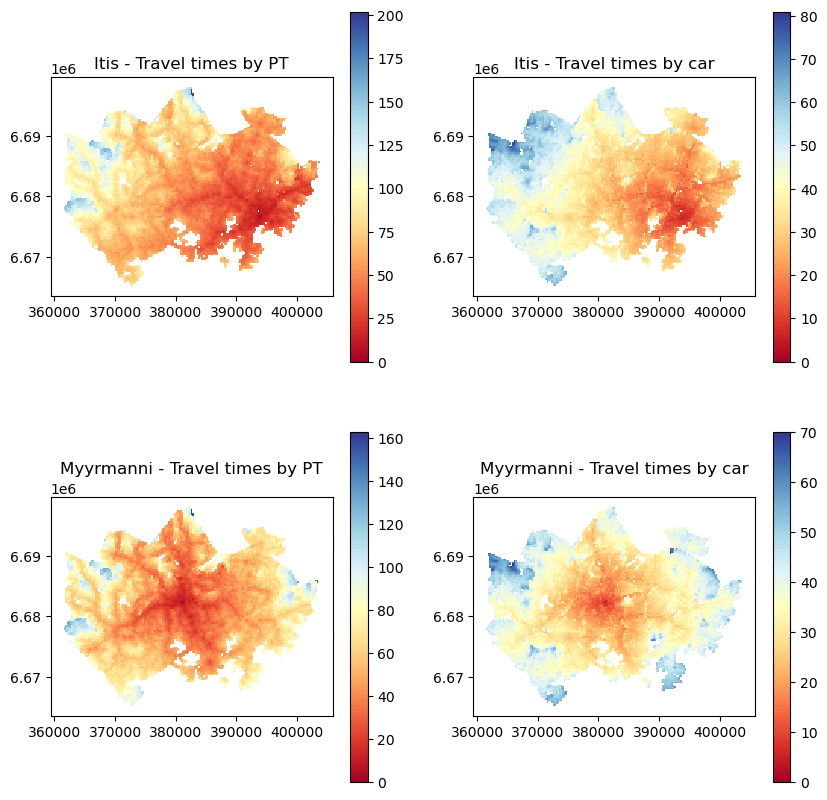

In [85]:
# ADD YOUR OWN CODE HERE
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax1_1 = axes[0][0]
ax1_2 = axes[0][1]
ax2_1 = axes[1][0]
ax2_2 = axes[1][1]

# Plot
grid.plot(ax=ax1_1,column="pt_r_t_Itis", cmap="RdYlBu",linewidth=0, legend=True)
grid.plot(ax=ax1_2,column="car_r_t_Itis", cmap="RdYlBu",linewidth=0, legend=True)
grid.plot(ax=ax2_1,column="pt_r_t_Myyrmanni", cmap="RdYlBu",linewidth=0, legend=True)
grid.plot(ax=ax2_2,column="car_r_t_Myyrmanni", cmap="RdYlBu",linewidth=0, legend=True)

# Titles
ax1_1.title.set_text('Itis - Travel times by PT')
ax1_2.title.set_text('Itis - Travel times by car')
ax2_1.title.set_text('Myyrmanni - Travel times by PT')
ax2_2.title.set_text('Myyrmanni - Travel times by car')
    

# Titles

plt.savefig(DATA_DIRECTORY/ "shopping_centre_accessibility.png")
    
    
plt.show()

In [83]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "shopping_centre_accessibility.png").exists()


---

**Finally**, check that you have provided adequate comments in your code.

---

### Reflections

If you want to ask feedback on spesific parts of your code, please leave your comment here

### Key Takeaways

This was a challenging but enjoyable and rewarding exercise. I now know how to combine non-spatial data with spatial data to uncover valuable insights.

I ran into lots of problems with this, centred around how to deal with NaNs, data type issue. It just reaffirms how important it is to be able to cleanse your data. Stack Overflow to the rescue as usual!  


---

### Done!

**Remember to commit the output figure** to your exercise repository!

That’s! Once you have plotted the data and saved the output, you are ready to proceed to *problem 2*.